# CNN Project Information

## Informace

You can get 10 to 20 points

Every project must include brief description of the dataset

Number of images, number of classes and class balance
Examples of the images
What metrics scores you have decided to use

e.g. Accuracy, Precision, Recall, F1-score etc.
Also state which one of the scores is the most important from your point of view given the class balance, task, ...
Try minimally 2 different models

The first model should be built from scratch, i.e. create your own architecture and train the model
If you perform various experiments or parameters tuning be sure to include everyting in the Notebook step by step with some brief comments about the experiments (e.g. effect of BatchNorm/layer sizes/optimizer on accuracy/train time/...)
The second model will employ transfer learning techniques
You can try any model you wish, e.g. ResNet, Inception, MobileNet, etc.
Take a look at this list and try at least one of them
Fine tune the model for your dataset and compare it with the first one
Mandatory part of every project is a summary at the end in which you summarize the most interesting insight obtained.

Result is a Jupyter Notebook with descriptions included or a PDF report + source codes.

Deadline is 3. 4. 2022

## Příklady datových sad

- https://www.kaggle.com/joosthazelzet/lego-brick-images
- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
- https://www.kaggle.com/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
- https://www.kaggle.com/sanikamal/horses-or-humans-dataset
- https://www.kaggle.com/ihelon/lego-minifigures-classification

# Vypracování projektu

In [1]:
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # images
import numpy as np #numpy
import tensorflow.compat.v2 as tf #use tensorflow v2 as a main 
import tensorflow.keras as keras # required for high level applications
from sklearn.model_selection import train_test_split # split for validation sets
from sklearn.preprocessing import normalize # normalization of the matrix
from scipy.signal import convolve2d # convolutionof the 2D signals
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import plotly.express as px
import cv2
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import tensorflow_addons as tfa
import time


## Vybraná datová sada


- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

## Proměnné projektu

In [2]:
PARENT_DIR = os.path.sep.join(['.', "chest_xray"])

TRAIN_DIR = os.path.sep.join([PARENT_DIR, "train"])  
TEST_DIR = os.path.sep.join([PARENT_DIR, "test"])
VALID_DIR = os.path.sep.join([PARENT_DIR, "val"])
IMG_SIZE = 150

LABELS = ["NORMAL", "PNEUMONIA"]

NORMAL = LABELS[0]
PNEU = LABELS[1]

In [3]:
TRAIN_DIR

'.\\chest_xray\\train'

## Pomocné metody

In [4]:
def load_data(data_dir):
    data = list()
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
                
    return np.array(data)

In [5]:
def show_history(history):
    plt.figure()
    for key in history.history.keys():
        plt.plot(history.epoch, history.history[key], label=key)
    plt.legend()
    plt.tight_layout()


In [6]:
def show_example(train_x, train_y, class_names=LABELS):
    plt.figure(figsize=(30, 30))
    for i in range(len(train_y)):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        if class_names is not None:
          plt.xlabel(class_names[train_y[i]])
    plt.show()

In [7]:
def separate_to_Xy(data):
    X = data[:, 0]
    y = data[:, 1]
    return X, y 

In [8]:
def size_inspection(X, y):
    X_size = X.shape
    y_size = y.shape
    print(f"X={X_size} y={y_size}")

In [9]:
def select_n_with(X, y, selected_class, n=10):
    indicies = np.random.choice(np.argwhere(y == LABELS.index(selected_class)).ravel(), n)

    X_selected = X[indicies]
    y_selected = y[indicies]

    return X_selected, y_selected

In [10]:
train_data_raw = load_data(TRAIN_DIR)
test_data_raw = load_data(TEST_DIR)
valid_data_raw = load_data(VALID_DIR)

C:\Users\Vojta\AppData\Local\Temp\ipykernel_17440\2321814567.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [11]:
X_train_raw, y_train_raw = separate_to_Xy(train_data_raw)
X_test_raw, y_test_raw = separate_to_Xy(test_data_raw)
X_valid_raw, y_valid_raw = separate_to_Xy(valid_data_raw)

In [12]:
plt.figure(figsize = (5,5))
test = X_train_raw[0]

<Figure size 360x360 with 0 Axes>

In [13]:
test.shape

(150, 150)

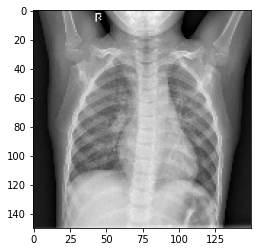

In [14]:
plt.imshow(test, cmap='gray')

In [15]:
size_inspection(X_train_raw, y_train_raw)
size_inspection(X_test_raw, y_test_raw)
size_inspection(X_valid_raw, y_valid_raw)

X=(5216,) y=(5216,)
X=(624,) y=(624,)
X=(16,) y=(16,)


## Informace ohledně datové sady

### Nemoc

#### Popis nemoci

- **Pneumonie** - Neboli zápal plic, je akutní nebo chronicky probíhající zánět plicního parenchymu na podkladě infekční, alergické, fyzikální nebo chemické noxy. Postihuje mikroskopické dutinky naplněné vzduchem.


#### Příznaky nemoci

- **Typické** - Mají klasické klinické symptomy pneumonie (horečka, kašel a dušnost). Jsou způsobeny bakteriálními patogeny. Na RTG se jeví jako lobulární, lobární, až alární pneumonie či bronchopneumonie, s tvorbou exsudátu v plicních sklípcích.
- **Atypické** - Projevují se symptomy netypickými pro bakteriální pneumonie (celkové „chřipkové“ příznaky – bolesti hlavy, svalů, kloubů, rovněž nevolnost, zvracení). Radiologický nález odpovídá diseminovanému plicnímu procesu.

#### Léčba

- Většinou vysoká citilovst na klasické ATB.


#### Představa snímku popisující jednotlivé třídy

- **Zdravé** - Obraz plic čistý bez jakéhokoliv "zmlžení".
- **Zápal plic** - V určité části plic tendece výskytu "zmlžení".

### Datová sada


#### Vizualizace datové sady

##### Zdravé

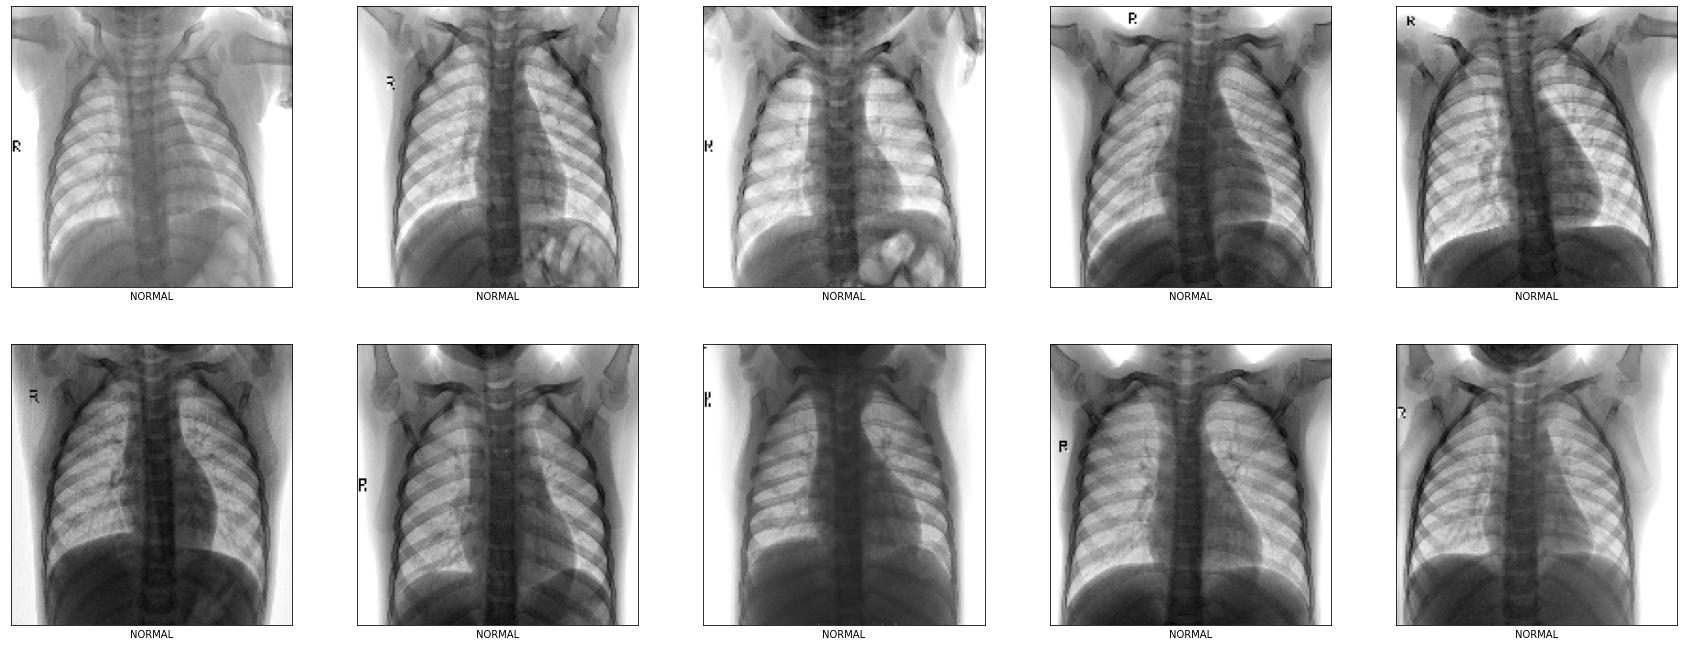

In [16]:
healthy_selected = select_n_with(X_train_raw, y_train_raw, NORMAL)
show_example(*healthy_selected)

##### Se zápalem plic

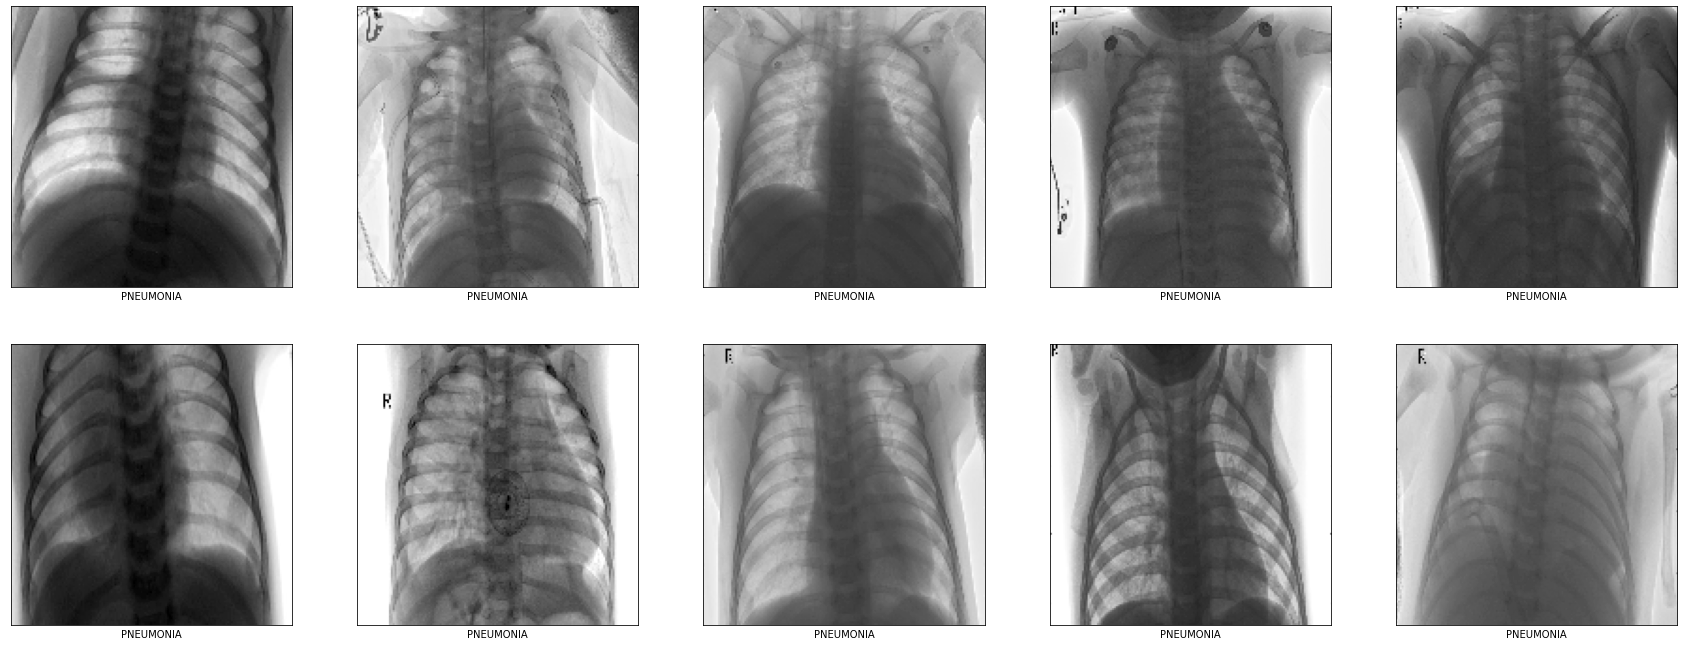

In [17]:
issue_selected = select_n_with(X_train_raw, y_train_raw, PNEU)
show_example(*issue_selected)

##### Počty

**Trénovací**

- Lze pozorovat, že trénovací sada je nevyvážená. Počet obrázků s diagnostikovaným zápalem plic je skoro 2 násobně více.

c:\Users\Vojta\Desktop\iv\MAD_CNN\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

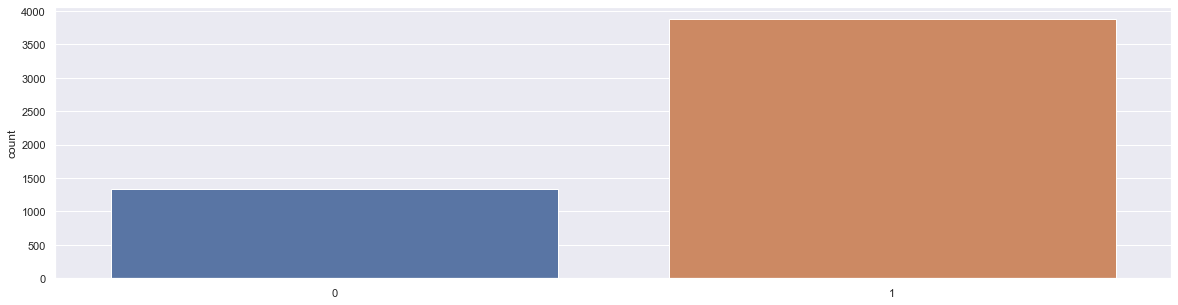

In [18]:
plt.figure(figsize=(20, 5))
sns.set_theme(style="darkgrid")
sns.countplot(y_train_raw)

**Validační**

- Oproti trénovací sadě je validační sada vyvážená.

c:\Users\Vojta\Desktop\iv\MAD_CNN\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

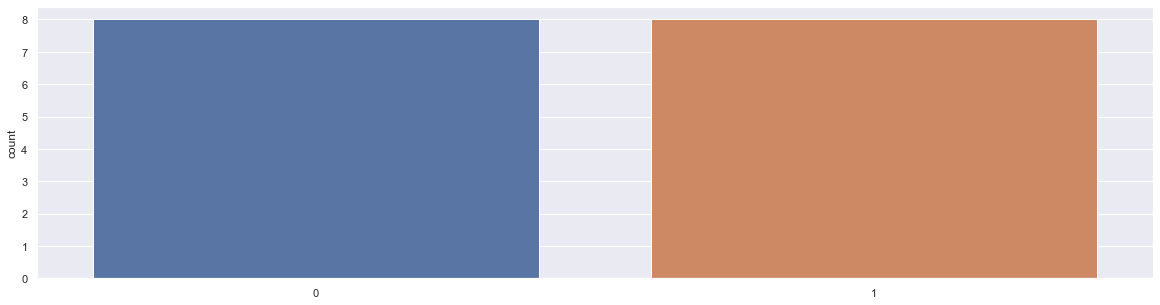

In [19]:
plt.figure(figsize=(20, 5))
sns.set_theme(style="darkgrid")
sns.countplot(y_valid_raw)

**Testovací**

- Obdobně jak bylo u trénovací sady, tak i u testovací množiny můžeme krásně pozorovat nevyváženost. Ačkoliv zde už to není takový problém. U trénovací sady dělá nevyváženost větší problém.

c:\Users\Vojta\Desktop\iv\MAD_CNN\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

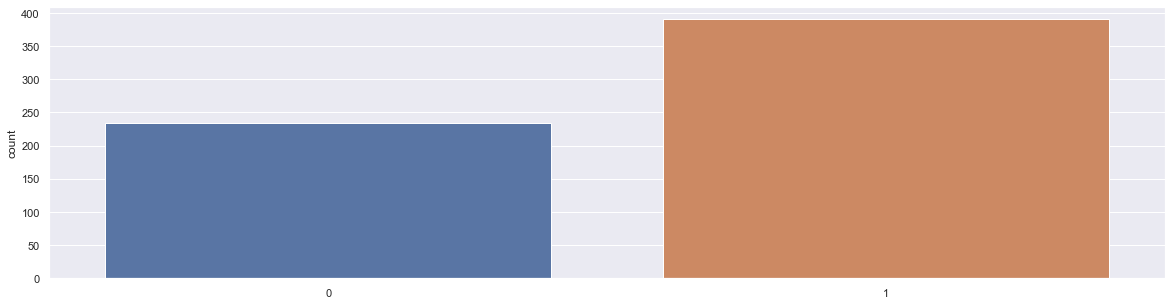

In [20]:
plt.figure(figsize=(20, 5))
sns.set_theme(style="darkgrid")
sns.countplot(y_test_raw)

## Jakou metriku použijeme?


### Vyhodnocení matice záměn

- TRUE POSITIVE - predikován normál, pravda normál
- TRUE NEGATIVE - predikován zápal, pravda je zápal
- FALSE POSITIVE - predikován normál, pravda je zápal. Chyba obrovská, jelikož je pacient ohrožen na životě, pokud bychom přepokládali poslání pacienta domů.
- FALSE NEGATIVE - predikován zápal, pravda je normál. Chyba není tak obrovská. Mohli bychom nasadit ATB, a pokud nepřepokládáme, že by léky pacientovi přitížili na stavu, pak by to stálo jen nemocnici zbytečné financování ATB.


### Výběr metriky

- Accuracy - přesnost nebude využita z důvodu, že trénovací množina je nevyvážená.
- Precision - metrika by byla vhodná. Bereme v potaz FALSE POSITIVE a tak náš nejbezpečnější případ by byl zhodnocen.
- Recall - metrika by byla vhodná. Ačkoliv Precision by se hodil v tomto případě více.
- F1 score - jakýsi průměr mezi recallem a precision metrikou. Proto bude v projektu primárně využita tato metrika. Bereme v potaz obě chyby.

## Klasifikace

In [21]:
results = {}

In [57]:
LEARNING_TIME = 'learn'
PREDICTION_TIME = 'prediction'

### Argumenty

##### Základní

In [22]:
EPOCHS = 10
BATCH_SIZE = 32

In [46]:
LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=False)
OPTIMIZER = tf.keras.optimizers.Adam()
METRICS = ['accuracy']

##### Callbacks

In [47]:
PATIENCE = 3
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True)

callbacks = [es]

##### Předzpracování


In [48]:
x_train = []
y_train = np.asarray(y_train_raw).astype('int8')

x_val = []
y_val = np.asarray(y_valid_raw).astype('int8')

x_test = []
y_test = np.asarray(y_test_raw).astype('int8')

for feature in X_train_raw:
    x_train.append(feature)

for feature in X_test_raw:
    x_test.append(feature)
    
for feature in X_valid_raw:
    x_val.append(feature)

In [26]:
X_train = np.array(x_train) / 255 
X_valid = np.array(x_val) / 255
X_test = np.array(x_test) / 255

In [49]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = y_train.reshape(-1, 1)

X_valid = X_valid.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = y_val.reshape(-1, 1)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = y_test.reshape(-1, 1)

In [50]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(5216, 150, 150, 1)
(16, 150, 150, 1)
(624, 150, 150, 1)


In [51]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(5216, 1)
(16, 1)
(624, 1)


In [52]:
def make_prediction_and_save(predicted, name, init_dic={}, true=y_test, dic=results):
    dic[name] = init_dic
    dic[name]['f1'] = f1_score(y_pred=predicted, y_true=true)

### Model 1 - vlastní architektura

In [53]:
name_own_1 = "own_cnn_architecture"
dic = {}


model = keras.Sequential([
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), input_shape=(150, 150, 1), activation='relu', padding='same'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1, activation='sigmoid'),                      
])

model.summary()

model.compile(
      loss=LOSS,
      optimizer=OPTIMIZER,
      metrics=METRICS              
)


tic = time.time()
history = model.fit(
      X_train, 
      y_train, 
      batch_size=BATCH_SIZE, 
      validation_data=(X_valid, y_val), 
      shuffle=True, 
      epochs=EPOCHS, 
      callbacks=callbacks
)
tac = time.time()

dic[LEARNING_TIME] = tac - tic

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_48 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_49 (Conv2D)          (None, 150, 150, 32)      9248      
                                                                 
 batch_normalization_49 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                      

KeyboardInterrupt: 

In [ ]:
show_history(history)

In [ ]:
tic = time.time()
prediction = model.predict(X_test_raw)
tac = time.time()

dic[PREDICTION_TIME] = tac - tic

make_prediction_and_save(prediction, name_own_1, dic)

### Model 2 - přenesené učení

In [55]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50

#### ResNET (ft) - přenesené učení

In [56]:
name_tl_1 = "ResNET (ft)"
trainable = True
dic = {}


resnet_model = ResNet50(weights='imagenet', include_top=False)

feature_extractor = resnet_model

for layer in feature_extractor.layers:
  layer.trainable = trainable

x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
prediction = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(resnet_model.input, prediction, name="res_net_with_head")

model.summary()

model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)

tic = time.time()
history = model.fit(
      X_train, 
      y_train, 
      batch_size=BATCH_SIZE, 
      validation_data=(X_valid, y_val), 
      shuffle=True, 
      epochs=EPOCHS, 
      callbacks=callbacks
)
tac = time.time()

dic[LEARNING_TIME] = tac - tic


12812288/94765736 [===>..........................] - ETA: 59s

KeyboardInterrupt: 

In [ ]:
show_history(history)

In [ ]:
tic = time.time()
prediction = model.predict(X_test_raw)
tac = time.time()


dic[PREDICTION_TIME] = tac - tic
make_prediction_and_save(prediction, name_tl_1, dic)

#### ResNET (bez ft) - přenesené učení

In [ ]:
name_tl_2 = "ResNET (bez ft)"
trainable = False
dic = {}


resnet_model = ResNet50(weights='imagenet', include_top=False)

feature_extractor = resnet_model

for layer in feature_extractor.layers:
  layer.trainable = trainable

x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
prediction = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(resnet_model.input, prediction, name="res_net_with_head")

model.summary()

model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)

tic = time.time()
history = model.fit(
      X_train, 
      y_train, 
      batch_size=BATCH_SIZE, 
      validation_data=(X_valid, y_val), 
      shuffle=True, 
      epochs=EPOCHS, 
      callbacks=callbacks
)
tac = time.time()

dic[LEARNING_TIME] = tac - tic

In [ ]:
show_history(history)

In [ ]:
tic = time.time()
prediction = model.predict(X_test_raw)
tac = time.time()


dic[PREDICTION_TIME] = tac - tic

make_prediction_and_save(prediction, name_tl_2, dic)

#### VGG (ft) - přenesené učení

In [ ]:
name_tl_3 = "VGG ft"
trainable = True
dic = {}


vgg_model = VGG19(weights='imagenet', include_top=False)

feature_extractor = vgg_model

for layer in feature_extractor.layers:
  layer.trainable = trainable

x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
prediction = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(vgg_model.input, prediction, name="vgg_with_head")

model.summary()

model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)

tic = time.time()
history = model.fit(
      X_train, 
      y_train, 
      batch_size=BATCH_SIZE, 
      validation_data=(X_valid, y_val), 
      shuffle=True, 
      epochs=EPOCHS, 
      callbacks=callbacks
)
tac = time.time()

dic[LEARNING_TIME] = tac - tic

In [ ]:
show_history(history)

In [ ]:
tic = time.time()
prediction = model.predict(X_test_raw)
tac = time.time()


dic[PREDICTION_TIME] = tac - tic

make_prediction_and_save(prediction, name_tl_3, dic)

#### VGG (bez ft) - přenesené učení

In [ ]:
name_tl_4 = "VGG (bez ft)"
trainable = False
dic = {}


vgg_model = VGG19(weights='imagenet', include_top=False)

feature_extractor = vgg_model

for layer in feature_extractor.layers:
  layer.trainable = trainable

x = tf.keras.layers.GlobalAveragePooling2D()(feature_extractor.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
prediction = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(vgg_model.input, prediction, name="vgg_with_head")

model.summary()

model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS
)

tic = time.time()
history = model.fit(
      X_train, 
      y_train, 
      batch_size=BATCH_SIZE, 
      validation_data=(X_valid, y_val), 
      shuffle=True, 
      epochs=EPOCHS, 
      callbacks=callbacks
)
tac = time.time()

dic[LEARNING_TIME] = tac - tic

In [ ]:
show_history(history)

In [ ]:
tic = time.time()
prediction = model.predict(X_test_raw)
tac = time.time()

dic[PREDICTION_TIME] = tac - tic

make_prediction_and_save(prediction, name_tl_4, dic)

### Výsledky

In [55]:
df = pd.DataFrame.from_dict(results, orient="index")

## Zhodnocení